In [75]:
import os
from pathlib import Path
import sys
sys.path.extend(['../../', '../../base'])
import re
import copy
import numpy as np
import imageio
import cv2
from scipy.ndimage import morphology
from scipy.stats import mode
import skimage.morphology
from matplotlib import pyplot as plt
from base.utils.mask_converter import MaskConverter
from base.utils.annotation_builder import AnnotationBuilder

In [128]:
import skimage
print(skimage.__version__)

0.14.2


In [8]:
converter = MaskConverter(min_contour_area=10000, fix_ambiguity=True)
aida_ann = AnnotationBuilder('17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi', 'test', ['epithelium', 'lumen', 'background'])

In [9]:
# debug error contours - assertion: this loop should end at close point
err_tiles = [
    '/mnt/rescomp/users/achatrian/ProstateCancer/Dataset/data/network_outputs/46496_24151_gland_lumen.png',
    '/mnt/rescomp/users/achatrian/ProstateCancer/Dataset/data/network_outputs/137128_52206_gland_lumen.png'
]

In [21]:
def plot_before_after(im1, im2):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

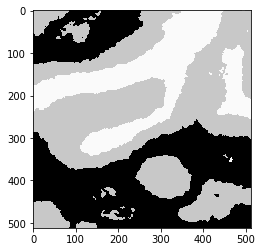

In [10]:
err_tile0 = imageio.imread(err_tiles[0])
plt.imshow(err_tile0)

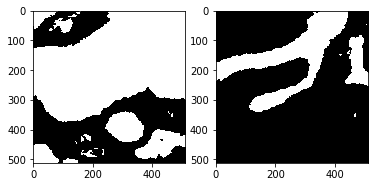

In [11]:
# show original class masks
binary_masks0 = []
for value in converter.label_value_map.values():
    if value == converter.label_value_map['background']:
        continue  # don't extract contours for background
    value_binary_mask = converter.threshold_by_value(value, err_tile0)
    binary_masks0.append(value_binary_mask)
fig, axes = plt.subplots(1, len(binary_masks0))
for i, axis in enumerate(axes):
    axis.imshow(binary_masks0[i] * 255)

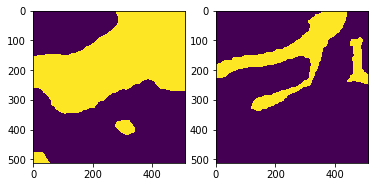

In [12]:
# show class masks
unambigous_masks0 = []
for mask in binary_masks0:
    umask = converter.remove_ambiguity(mask)
    unambigous_masks0.append(umask)
fig, axes = plt.subplots(1, len(binary_masks0))
for i, axis in enumerate(axes):
    axis.imshow(unambigous_masks0[i] * 255)

In [46]:
# debug - remove ambiguity makes glands too small
mask3c = copy.deepcopy(err_tile0)
mask = copy.deepcopy(err_tile0)[..., 0].astype(np.uint8)
mask = converter.threshold_by_value(200, mask).astype(np.uint8)

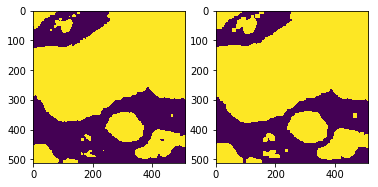

In [42]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
# refine -ve area (includes background)
refined_bg = cv2.dilate(opening, kernel, iterations=3)
plot_before_after(opening, refined_bg)

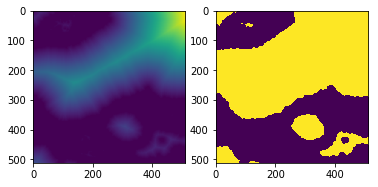

In [52]:
# refine foreground area
dist_threshold=0.03
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, refined_fg = cv2.threshold(dist_transform, dist_threshold * dist_transform.max(), 255, 0)
refined_fg = np.uint8(refined_fg)
plot_before_after(dist_transform, refined_fg)

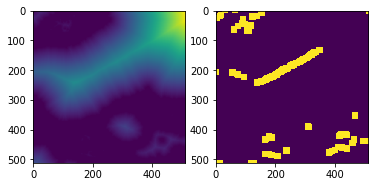

In [72]:
# check maxima of distance transform
maxima = skimage.morphology.local_maxima(dist_transform)
maxima = cv2.dilate(maxima.astype(np.uint8), kernel, iterations=10)
plot_before_after(dist_transform, maxima)

In [127]:
# Find median value of local maxima
maxima = skimage.morphology.local_maxima(dist_transform, indices=True)
maxima = np.stack(maxima, axis=0).T
# test = np.zeros_like(dist_transform)
# for y, x in maxima:
#     test[y-2:y+2, x-2:x+2] = 255
# plt.imshow(test)
values_at_maxima = np.array(list(dist_transform[y, x] for y, x in maxima))
mode_of_maxima = mode(values_at_maxima)[0].item()
median_of_maxima = np.median(values_at_maxima)
mean_of_maxima = np.mean(values_at_maxima)
print(mode_of_maxima, median_of_maxima, mean_of_maxima, dist_transform.max())

3.0 25.393795 59.882893 257.7256


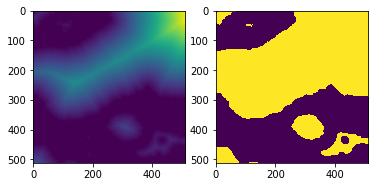

In [126]:
# refine foreground area using local instead of absolute maxima
dist_threshold=3.0
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, refined_fg = cv2.threshold(dist_transform, dist_threshold * mode_of_maxima, 255, 0)
refined_fg = np.uint8(refined_fg)
plot_before_after(dist_transform, refined_fg)

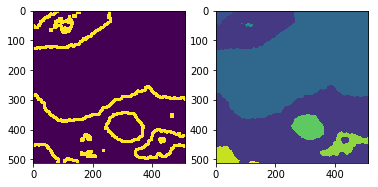

In [53]:
 # finding unknown region
unknown = cv2.subtract(refined_bg, refined_fg)
# marker labelling
ret, markers = cv2.connectedComponents(refined_fg)
markers = markers + 1
# mark the region of unknown with zero
markers[unknown == 250] = 0
# watershed
markers = cv2.watershed(mask3c, markers)
plot_before_after(unknown, markers)

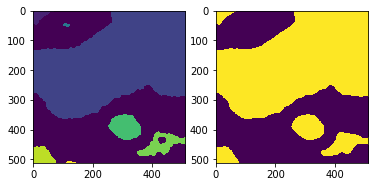

In [65]:
# threshold out boundaries and background (-1 and 0 respectively)
markers = cv2.morphologyEx(cv2.medianBlur(markers.astype(np.uint8), 3), cv2.MORPH_OPEN, kernel, iterations=2)
unambiguous = np.uint8(cv2.medianBlur(markers.astype(np.uint8), 15) > 1) * 255
# filled holes if any in larger objects
unambiguous = morphology.binary_fill_holes(unambiguous)
unambiguous = skimage.morphology.remove_small_objects(unambiguous, min_size=150)
plot_before_after(markers, unambiguous)

In [61]:
200/(500 **2)

0.0008

In [66]:
150/500

0.3